In [1]:
# Data Loading

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [2]:
# KNN Implementation

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [88]:
def euclidean(x_test, x_train):
    return np.sqrt(np.sum((x_train - x_test)**2,axis=1))

def manhattan(x_test, x_train):
    return np.sum(np.abs(x_train - x_test), axis=1)

In [93]:
class KNearestNeighbors():

    def __init__(self, x_train, y_train, distance=euclidean, k=5):
        self.x_train = x_train
        self.y_train = y_train
        self.distance = euclidean
        self.k = k

    def predict(self, x_test):
        assignments = []
        for x in x_test:
            distances = self.distance(x, self.x_train)
            nearest_indices = np.argsort(distances)
            neighbors = self.y_train[nearest_indices[:self.k]]
            labels, counts = np.unique(neighbors.flatten(),return_counts=True)
            assignments += [labels[np.argmax(counts)]]
        self.y_pred = np.array(assignments)
        return self.y_pred
    
    def f1(self, y_test):
        recall = self.recall(y_test)
        precision = self.recall(y_test)
        return 2 * recall * precision / (precision + recall).clip(1e-8)

    def recall(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fn = sum((self.y_pred == 'M') & (y_test == 'B'))
        return tp / (tp+fn).clip(1e-8)
    
    def precision(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fp = sum((self.y_pred == 'B') & (y_test == 'M'))
        return tp / (tp+fp).clip(1e-8)
    
    def accuracy(self, y_test):
        return sum(self.y_pred == y_test) / len(y_test)
    


In [94]:
# First pass: split 80/20 for train/test

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9210526315789473 0.9836065573770492 0.9836065573770492


In [95]:
# Compare with Manhattan distance

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train,distance=manhattan)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9210526315789473 0.9836065573770492 0.9836065573770492


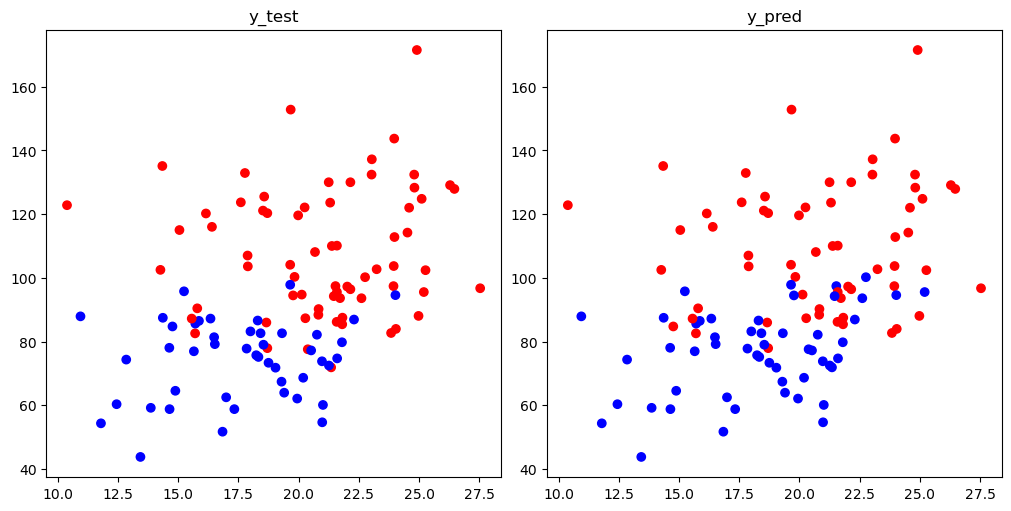

In [91]:
fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_pred])
ax[1].set_title('y_pred')
plt.show()

Text(0, 0.5, 'F1')

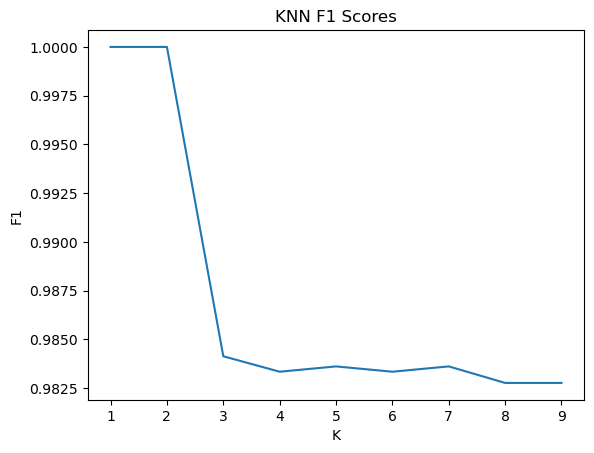

In [97]:
# Examine different values of k

f1s = []
preds = []
ks = range(1, 10)
for k in ks:
    knn = KNearestNeighbors(x_train, y_train, k=k)
    preds += [knn.predict(x_test)]
    f1s += [knn.f1(y_test)]

plt.plot(ks, f1s)
plt.title('KNN F1 Scores')
plt.xlabel('K')
plt.ylabel('F1')

In [76]:
# Examine across k-folds

accuracies = []
recalls = []
f1s = []
preds = []

for i in np.arange(5):

    # define folds
    x_train = np.array_split(X.values,5)
    y_train = np.array_split(y.values,5)

    x_test, y_test = x_train.pop(i), y_train.pop(i).flatten()
    x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

    # run algorithm and eval
    knn = KNearestNeighbors(x_train, y_train, k=2)
    preds += [knn.predict(x_test)]
    accuracies.append(knn.accuracy(y_test))
    recalls.append(knn.recall(y_test))
    f1s.append(knn.f1(y_test))

Text(0, 0.5, 'Recall')

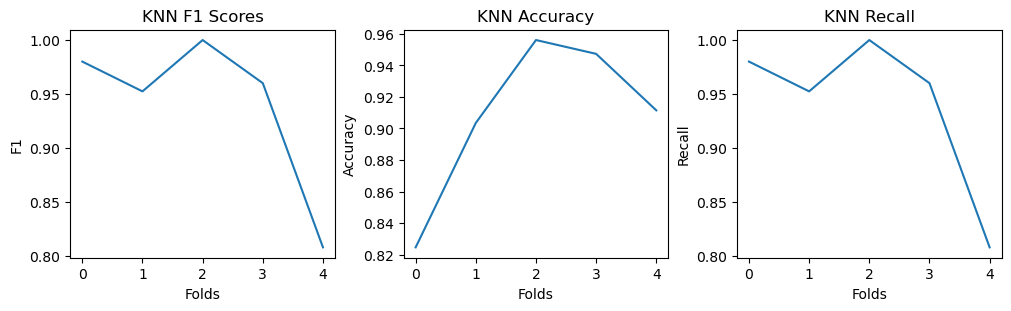

In [84]:
fig,axs = plt.subplots(1,3,layout='constrained',figsize=(10,3))

axs[0].plot(np.arange(5), f1s)
axs[0].set_title('KNN F1 Scores')
axs[0].set_xlabel('Folds')
axs[0].set_ylabel('F1')

axs[1].plot(np.arange(5), accuracies)
axs[1].set_title('KNN Accuracy')
axs[1].set_xlabel('Folds')
axs[1].set_ylabel('Accuracy')

axs[2].plot(np.arange(5), recalls)
axs[2].set_title('KNN Recall')
axs[2].set_xlabel('Folds')
axs[2].set_ylabel('Recall')

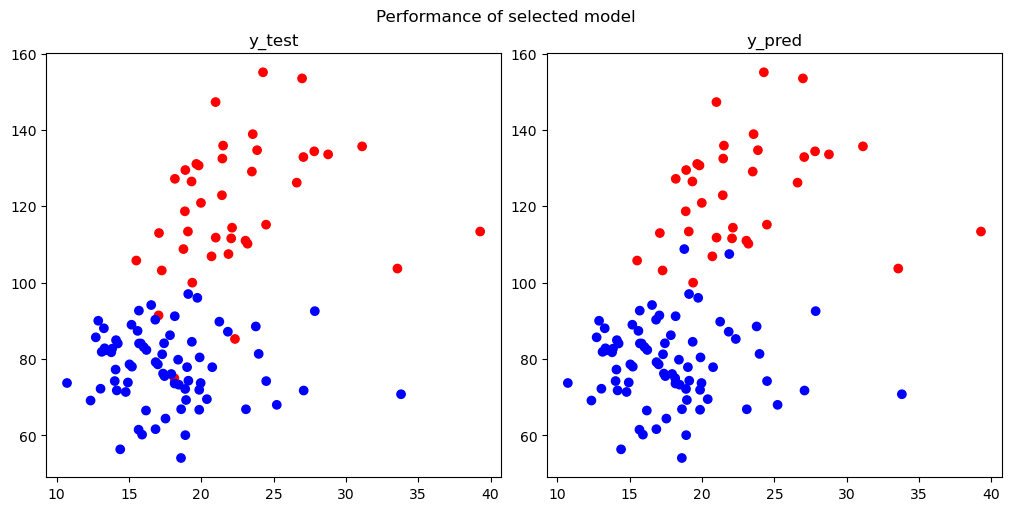

In [87]:
x_train = np.array_split(X.values,5)
y_train = np.array_split(y.values,5)
x_test, y_test = x_train.pop(2), y_train.pop(2).flatten()
x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in preds[2]])
ax[1].set_title('y_pred')
fig.suptitle('Performance of selected model')
plt.show()

In [ ]:
# Nominated model: k=2, 2nd fold